In [1]:
from os import path
import re
import numpy as np
import matplotlib.pyplot as plt
from grobid_quantities.quantities import QuantitiesClient


INPUT_FILE = path.join('data',
                       '2022_JBR_Spring_Internship_Test_Data.csv')

### Чтение входных данных

Сохраним все данные в список кортежей `data`, где в каждом кортеже нулевой элемент соответвтвует PubMed ID, первый -- аннотации.

В тексте каждой аннотации заменим двойные кавычки на одинарные, т.к. в противном случае при обработке возникает `JSONDecodeError`. Также заменим юникод-символы на `?`, потому что некоторые из них препятствуют обработке текста в `grobid-quantities` (`DEBUG - Disambugation failed.`). Такой подход явно не является оптимальным, т.к. некоторые удаляемые символы (например, $\pm$) успешно обрабатываются `grobid-quantities`.

In [2]:
data = []
pattern = re.compile('(\d{1,8}\.?\d.),\"?(.*?)\"?$')

with open(INPUT_FILE, 'r') as f:
    next(f)  # пропуск шапки
    for line in f:
        match = re.match(pattern, line.strip())
        if match:
            pmid = match.group(1)
            abstract = match.group(2).replace('\"', '\'')
            abstract = abstract.encode('ascii', 'replace')
            data.append((pmid, abstract))

print(f'Всего прочитано {len(data)} аннотаций.')
data[0]

Всего прочитано 1429 аннотаций.


('35103873',
 b'It has been a challenge for solving the motor imagery classification problem in the brain informatics area. Accuracy and efficiency are the major obstacles for motor imagery analysis in the past decades since the computational capability and algorithmic availability cannot satisfy complex brain signal analysis. In recent years, the rapid development of machine learning (ML) methods has empowered people to tackle the motor imagery classification problem with more efficient methods. Among various ML methods, the Graph neural networks (GNNs) method has shown its efficiency and accuracy in dealing with inter-related complex networks. The use of GNN provides new possibilities for feature extraction from brain structure connection. In this paper, we proposed a new model called MCGNet<sup>+</sup>, which improves the performance of our previous model MutualGraphNet. In this latest model, the mutual information of the input columns forms the initial adjacency matrix for the cosi

### Извлечение всех численных показателей

Следуя заданию, сохраняем только тип значений `value`.

In [3]:
client = QuantitiesClient(apiBase='http://localhost:8060/service')

In [4]:
measurements = []

for _, abstract in data:
    _, response = client.process_text(abstract)
    if response and 'measurements' in response:
        for m in response['measurements']:
            if m['type'] == 'value':
                measurements.append(m)

print('Всего найдено {len(measurements)} численных показателей.')

Всего найдено {len(measurements)} численных показателей.


### Поиск значений, относящихся к слову "accuracy"

In [5]:
accuracies = []
for m in measurements:
    if 'quantified' in m and m['quantified']['normalizedName'] == 'accuracy':
        value = m['quantity']['parsedValue']
        if 'numeric' in value:
            accuracies.append(value['numeric'])

print(f'Всего найдено {len(accuracies)} значений accuracy.')
print(f'Минимум: {min(accuracies)}.')
print(f'Максимум: {max(accuracies)}.')
print(f'Медиана: {np.median(accuracies)}.')

Всего найдено 113 значений accuracy.
Минимум: -0.657.
Максимум: 1201.
Медиана: 81.38.


Посмотрим, какая доля значений "accuracy" не лежит в диапазоне $[0, 100]$. 

In [6]:
outliers = [acc for acc in accuracies if (acc < 0 or acc > 100)]

len(outliers) / len(accuracies) * 100

4.424778761061947

In [7]:
outliers

[-0.552, -0.543, -0.582, -0.657, 1201]

Т.к. таких значений немного, построим гистограмму только для интервала $[0, 100]$.

Text(0.5, 0, 'Accuracy')

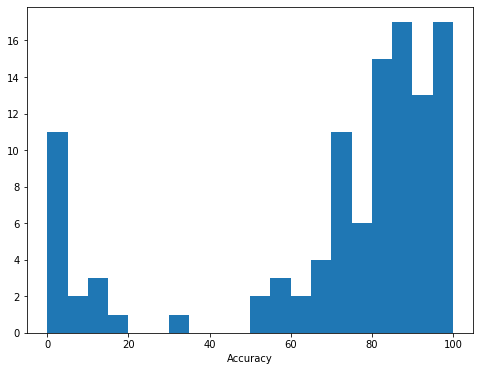

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(accuracies, bins=np.arange(0, 101, 5))
plt.xlabel('Accuracy')

Первый бин ($<5$%), возможно, соответствует значениям точности, записаными в десятичной форме. Проверим это предположение.

In [9]:
[acc for acc in accuracies if (acc > 0 and acc < 1)]

[0.045, 0.011, 0.59, 0.0022]